https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers

In [3]:
import pandas as pd
import numpy as np
train = pd.read_csv('/Users/wangluya/PycharmProjects/datasets/digit_recognizer/train.csv',dtype = np.float32)
# test= pd.read_csv('/Users/wangluya/PycharmProjects/datasets/digit_recognizer/test.csv',dtype = np.float32)
# print(f'训练数据shape: {train_data.shape}')
# print(f'测试数据shape: {test_data.shape}')

In [5]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split

In [7]:
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is  long
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long


In [8]:
featuresTest[0].shape 

torch.Size([784])

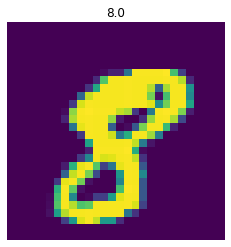

In [23]:
# visualize one of the images in data set
import matplotlib.pyplot as plt

plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [19]:
targetsTest[0]

tensor(8)

In [20]:
print(featuresTest.shape ,featuresTrain.shape)

torch.Size([8400, 784]) torch.Size([33600, 784])


In [21]:
print(targetsTest.shape,targetsTrain.shape)

torch.Size([8400]) torch.Size([33600])


举个例子，训练集有1000个样本，batchsize=10，那么：

训练完整个样本集需要：

100次iteration，1次epoch。

In [9]:
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)



In [10]:
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# Create Logistic Regression Model

In [11]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        # Linear part
        self.linear = nn.Linear(input_dim, output_dim)
        # There should be logistic function right?
        # However logistic function in pytorch is in loss function
        # So actually we do not forget to put it, it is only at next parts
    
    def forward(self, x):
        out = self.linear(x)
        return out

# Instantiate Model Class
input_dim = 28*28 # size of image px*px
output_dim = 10  # labels 0,1,2,3,4,5,6,7,8,9

# create logistic regression model
model = LogisticRegressionModel(input_dim, output_dim)

# Cross Entropy Loss  
error = nn.CrossEntropyLoss()

# SGD Optimizer 
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)      

In [12]:
# Traning the Model
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Define variables
        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Calculate gradients
        loss.backward()

        # Update parameters
        optimizer.step()
        
        count += 1
        
        # Prediction
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader: 
                test = Variable(images.view(-1, 28*28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {}%'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 1.8384546041488647  Accuracy: 67.55952453613281%
Iteration: 1000  Loss: 1.615545392036438  Accuracy: 76.23809814453125%
Iteration: 1500  Loss: 1.2872425317764282  Accuracy: 79.25%
Iteration: 2000  Loss: 1.215653896331787  Accuracy: 80.66666412353516%
Iteration: 2500  Loss: 1.0347774028778076  Accuracy: 81.47618865966797%
Iteration: 3000  Loss: 0.9308755993843079  Accuracy: 82.20237731933594%
Iteration: 3500  Loss: 0.8958402276039124  Accuracy: 82.91666412353516%
Iteration: 4000  Loss: 0.7469171285629272  Accuracy: 83.44047546386719%
Iteration: 4500  Loss: 0.9625682830810547  Accuracy: 83.8452377319336%
Iteration: 5000  Loss: 0.7988636493682861  Accuracy: 84.13095092773438%
Iteration: 5500  Loss: 0.7525433301925659  Accuracy: 84.47618865966797%
Iteration: 6000  Loss: 0.8641594052314758  Accuracy: 84.66666412353516%
Iteration: 6500  Loss: 0.6635234951972961  Accuracy: 84.82142639160156%
Iteration: 7000  Loss: 0.7148967981338501  Accuracy: 85.08333587646484%
Iteratio

In [46]:
torch.save(model,'./save_model/model.pkl')

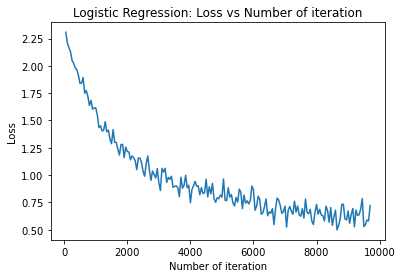

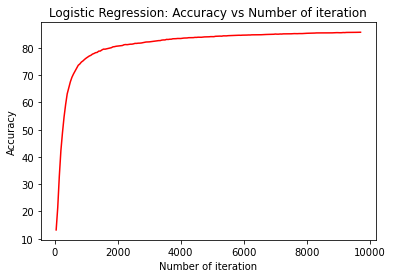

In [14]:
# visualization
import matplotlib.pyplot as plt

plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Logistic Regression: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Logistic Regression: Accuracy vs Number of iteration")
plt.show()

# ANN

In [17]:
class ANNModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        
        # Linear function 1: 784 --> 150
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity 1
        self.relu1 = nn.ReLU()
        
        # Linear function 2: 150 --> 150
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.tanh2 = nn.Tanh()
        
        # Linear function 3: 150 --> 150
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3
        self.elu3 = nn.ELU()
        
        # Linear function 4 (readout): 150 --> 10
        self.fc4 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)
        
        # Linear function 2
        out = self.fc3(out)
        # Non-linearity 2
        out = self.elu3(out)
        
        # Linear function 4 (readout)
        out = self.fc4(out)
        return out

# instantiate ANN
input_dim = 28*28
hidden_dim = 150 #hidden layer dim is one of the hyper parameter and it should be chosen and tuned. For now I only say 150 there is no reason.
output_dim = 10

# Create ANN
ann_model = ANNModel(input_dim, hidden_dim, output_dim)

# Cross Entropy Loss 
ann_error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.02
ann_optimizer = torch.optim.SGD(ann_model.parameters(), lr=learning_rate)

In [18]:
# Traning the Model
count = 0
ann_loss_list = []
ann_iteration_list = []
ann_accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Define variables
        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        # Clear gradients
        ann_optimizer.zero_grad()
        
        # Forward propagation
        outputs = ann_model(train)
        
        # Calculate softmax and cross entropy loss
        loss = ann_error(outputs, labels)
        
        # Calculate gradients
        loss.backward()

        # Update parameters
        ann_optimizer.step()
        
        count += 1
        
        # Prediction
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader: 
                test = Variable(images.view(-1, 28*28))
                
                # Forward propagation
                outputs = ann_model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            ann_loss_list.append(loss.data)
            ann_iteration_list.append(count)
            ann_accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {}%'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 0.715939998626709  Accuracy: 79.4047622680664%
Iteration: 1000  Loss: 0.47296833992004395  Accuracy: 87.48809814453125%
Iteration: 1500  Loss: 0.24192382395267487  Accuracy: 89.44047546386719%
Iteration: 2000  Loss: 0.2973266839981079  Accuracy: 90.54762268066406%
Iteration: 2500  Loss: 0.3115991950035095  Accuracy: 91.92857360839844%
Iteration: 3000  Loss: 0.12147693336009979  Accuracy: 92.5952377319336%
Iteration: 3500  Loss: 0.2350340634584427  Accuracy: 93.38095092773438%
Iteration: 4000  Loss: 0.06445293873548508  Accuracy: 93.89286041259766%
Iteration: 4500  Loss: 0.30656468868255615  Accuracy: 94.45237731933594%
Iteration: 5000  Loss: 0.10375180840492249  Accuracy: 94.58333587646484%
Iteration: 5500  Loss: 0.19827821850776672  Accuracy: 94.8452377319336%
Iteration: 6000  Loss: 0.20407874882221222  Accuracy: 95.02381134033203%
Iteration: 6500  Loss: 0.09878801554441452  Accuracy: 95.52381134033203%
Iteration: 7000  Loss: 0.12632644176483154  Accuracy: 95.797

In [40]:
torch.save(ann_model,'./save_model/ann_model.pkl')

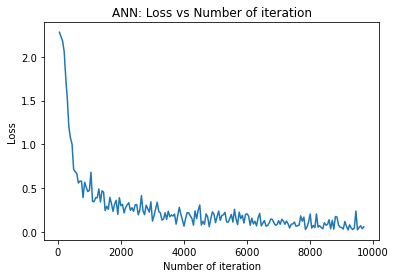

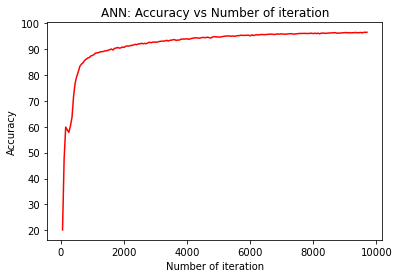

In [19]:
# visualization loss 
plt.plot(ann_iteration_list,ann_loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(ann_iteration_list,ann_accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()

# CNN

#        # Define variables
#        # train = Variable(images.view(-1, 28*28))
#       train = Variable(images.view(100,1,28,28))  #torch.Size([100, 1, 28, 28])

In [4]:
# Import Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable

In [6]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
       
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # flatten
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

# batch_size, epoch and iteration
batch_size = 100
n_iters = 2500
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create CNN
cnn_model = CNNModel()

# Cross Entropy Loss 
cnn_error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.1
cnn_optimizer = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate)

In [43]:
# Traning the Model
count = 0
cnn_loss_list = []
cnn_iteration_list = []
cnn_accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Define variables
        # train = Variable(images.view(-1, 28*28))
        train = Variable(images.view(100,1,28,28))  #torch.Size([100, 1, 28, 28])
        labels = Variable(labels)
        
        # Clear gradients
        cnn_optimizer.zero_grad()
        
        # Forward propagation
        outputs = cnn_model(train)
        
        # Calculate softmax and cross entropy loss
        cnn_loss = cnn_error(outputs, labels)
        
        # Calculate gradients
        cnn_loss.backward()

        # Update parameters
        cnn_optimizer.step()
        
        count += 1
        
        # Prediction
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader: 
                # test = Variable(images.view(-1, 28*28))
                test = Variable(images.view(100,1,28,28))
                
                # Forward propagation
                outputs = cnn_model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            cnn_loss_list.append(cnn_loss.data)
            cnn_iteration_list.append(count)
            cnn_accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {}%'.format(count, cnn_loss.data, accuracy))

Iteration: 500  Loss: 0.09116720408201218  Accuracy: 96.5%
Iteration: 1000  Loss: 0.04660368338227272  Accuracy: 97.66666412353516%
Iteration: 1500  Loss: 0.03077489696443081  Accuracy: 97.69047546386719%
Iteration: 2000  Loss: 0.02033318020403385  Accuracy: 98.16666412353516%


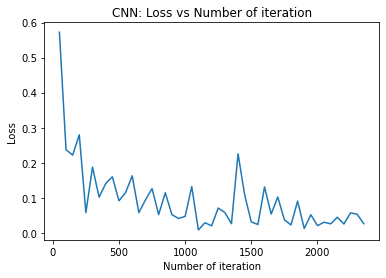

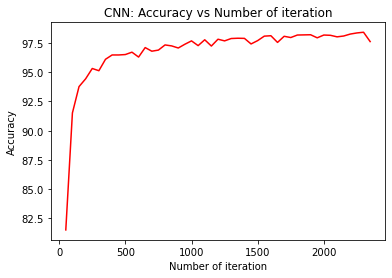

In [44]:
# visualization loss 
plt.plot(cnn_iteration_list,cnn_loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(cnn_iteration_list,cnn_accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [45]:
torch.save(cnn_model,'./save_model/cnn_model.pkl')

# 加载模型 来预测 加载真正的测试集，提交

In [7]:
import torch
PATH='./save_model/cnn_model.pkl'
# predict_model=CNNModel()
# 这样不行，因为保存的时候不是torch.save(cnn_model.state_dict(),PATH)的形式，你得配套用
# predict_model.load_state_dict(torch.load(PATH))


PATH='./save_model/cnn_model.pkl'
predict_model=torch.load(PATH)




In [8]:
print(torch.__version__)

1.7.1


In [ ]:
# torch.save(cnn_model,'./save_model/cnn_model_2.pkl')

+ __注意下面的images\[0\]，因为一开始real_test = torch.utils.data.TensorDataset(featuresRealTest) 就只加了featuresRealTest，所以和上面的训练集、验证集有所区别__

In [64]:
real_test= pd.read_csv('/Users/wangluya/PycharmProjects/datasets/digit_recognizer/test.csv',dtype = np.float32)
features_real_test = real_test.values/255 # normalization
featuresRealTest = torch.from_numpy(features_real_test)
real_test = torch.utils.data.TensorDataset(featuresRealTest)

# data loader
real_test_loader = DataLoader(real_test, batch_size = batch_size, shuffle = False)



for index,images in enumerate(real_test_loader): 
    
    # print(index,len(images),type(images[0]),images[0].shape)
    test = Variable(images[0].view(100,1,28,28)) 
    
    # Forward propagation
    outputs = cnn_model(test)
    _, prediction = torch.max(outputs, 1)
    prediction = prediction.numpy()[0]
    print(prediction)
    # print(len(outputs),outputs.shape,outputs[1])
    # break


2
0
1
6
9
6
5
4
1
5
0
4
4
6
1
0
8
2
0
6
8
7
1
2
9
3
2
7
4
2
6
2
8
1
6
8
8
5
8
1
4
5
3
9
9
3
8
5
0
9
1
9
6
0
0
4
8
6
8
0
1
1
8
8
9
5
1
7
6
3
8
0
5
1
2
2
4
4
9
9
6
6
2
5
5
1
9
4
7
9
3
5
7
2
0
4
8
7
3
0
0
3
1
9
8
3
5
6
7
7
5
0
4
5
9
0
5
1
2
5
9
3
8
4
3
8
6
4
0
6
8
0
2
4
6
2
7
1
8
6
3
4
1
7
1
2
8
6
4
1
2
6
8
0
3
1
9
1
3
2
4
8
9
1
1
2
6
9
1
7
3
0
1
6
2
5
8
8
6
3
9
2
1
5
4
1
2
2
7
3
2
3
1
0
9
5
5
3
3
0
7
1
5
3
7
1
3
4
9
3
7
0
8
7
6
3
2
7
0
4
0
2
4
5
9
2
7
9
8
0
4
8
8
7
2
3
1
9
0
4
7
8
8
2
4
6
3
9
0
5
2
7
3
6
7
0
4
5
2
1
7
3
1
4
9
7
3
0
4
4
2
0
0
5
7
5
7
5
3
2


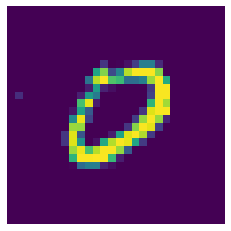

In [69]:
import matplotlib.pyplot as plt

plt.imshow(features_real_test[3].reshape(28,28))
plt.axis("off")
plt.savefig('graph.png')
plt.show()

In [16]:
import numpy as np
import pandas as pd
real_test= pd.read_csv('/Users/wangluya/PycharmProjects/datasets/digit_recognizer/test.csv',dtype = np.float32)
features_real_test = real_test.values/255 # normalization
print(features_real_test.shape) # 

test = features_real_test.reshape(-1,1,28,28) # (-1,28,28,1)是错的
test=torch.from_numpy(test)
print(type(test),test.shape) # 

(28000, 784)
<class 'torch.Tensor'> torch.Size([28000, 1, 28, 28])


In [17]:
PATH='./save_model/cnn_model.pkl'
predict_model=torch.load(PATH)

In [30]:
# predict results
results = predict_model(test)
print(type(results))

<class 'torch.Tensor'>


In [31]:
print(results.shape)
print(results[0])

torch.Size([28000, 10])
tensor([  2.0957,  -4.6439,  21.7144,   1.7328,  -6.8833,  -4.9755, -11.5766,
         10.0789,  -0.0531,  -4.3777], grad_fn=<SelectBackward>)


In [36]:
# select the indix with the maximum probability
results1 = torch.max(results,1)[1] # torch.max()[1]     只返回最大值的每个索引
print(results1[0],type(results1),len(results1))



tensor(2) <class 'torch.Tensor'> 28000


In [37]:
results2 = pd.Series(results1,name="Label")

In [39]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results2],axis = 1)

submission.to_csv("save_model/cnn_mnist_datagen.csv",index=False)